## Mapping of arbitrage opportunities

In [1]:
#Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.basemap import Basemap as Basemap

In [6]:
#Reading the datasets
df = pd.read_csv("worldcities.csv")
df_wine = pd.read_csv("wines_vinmonopolet.csv")
df_arbitrage = pd.read_csv("arbitrage_wines.csv")

#Storing every capital of Europe in it's own dataset
df_primary_cities_europe = df[df["CapitalEurope"] == "Yes"].reset_index()

In [7]:
#Finding the wine-countries
wine_countries = list(set(df_wine.loc[:, "Country"]))

#Creating a list to store all wine countries from Europe
wine_countries_europe = []

#Iterating over all wines, checking whether it is a wine country in Europe
for row in range(len(wine_countries)):
    
    #Checking whether the country is a wine country
    if wine_countries[row] in list(df_primary_cities_europe.loc[:, "country"]):
        wine_countries_europe.append(wine_countries[row])

#Creating a dataframe based on 
df_wine_countries_europe = df_primary_cities_europe[df_primary_cities_europe["country"].isin(wine_countries_europe)].reset_index()

## Displaying the arbitrage opportunities by region

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


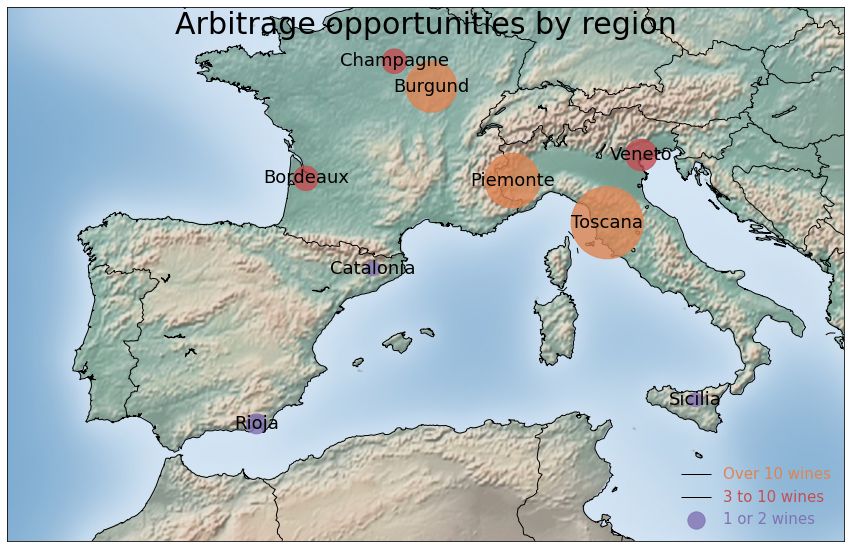

In [8]:
#Removing the non-european 
df_arbitrage = df_arbitrage[df_arbitrage["country"].isin(list(df_wine_countries_europe.loc[:, "country"]))]
gb_arbitrage = df_arbitrage.groupby("region")["name"].count()
unique_regions_arbitrage = set(gb_arbitrage.index)
arbitrage_regions = zip(gb_arbitrage.index, gb_arbitrage)

#Creating positional dictionary
premium_wine_regions = {
    "name" : [],
    "lat" : [],
    "lon" : []
}

#Getting lat and long for geolocated data
for city in unique_regions_arbitrage:
    name = city
    city = city.lower().strip()
    
    #Checking first if the region is in either 'city'- or 'city_ascii' column
    if (city.lower() in [city.lower().strip() for city in df.loc[:, "city"]]) or (city in [city.lower().strip() for city in df.loc[:, "city_ascii"]]): 
        
        #If we get a match, we iterate over to get the lat and long values
        for i in range(df.shape[0]):
            #Need to check both columns since we got both cities and regions.
            #Cities/Regions 1
            if name.lower().strip() == df.loc[i, "city"].lower().strip():
                name = name.strip()
                premium_wine_regions["name"].append(name)
                premium_wine_regions["lat"].append(df.loc[i, "lat"])
                premium_wine_regions["lon"].append(df.loc[i, "lng"])
                break
                
            #Cities/Regions 2
            if name.lower().strip() == df.loc[i, "city_ascii"].lower().strip():
                name = name.strip()
                premium_wine_regions["name"].append(name)
                premium_wine_regions["lat"].append(df.loc[i, "lat"])
                premium_wine_regions["lon"].append(df.loc[i, "lng"])
                break

df_arbitrage_regions = pd.DataFrame(premium_wine_regions)
#Creating the undirected graph
G = nx.Graph()

#Creating the nodes, adding them to the graph
nodes = [city for city in df_arbitrage_regions.loc[:, "name"]]
G.add_nodes_from(nodes)

#Creating the figure
FIG = plt.figure(figsize= (15,15))

#Drawing the map
m = Basemap(projection='mill', llcrnrlon = -12, llcrnrlat = 33 ,urcrnrlon = 20 ,urcrnrlat = 50,
            resolution='i')

#Adjusting the Basemap
m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth = 1)
m.shadedrelief()

#Creating a positional of lat and long values
origin, dest = m(df_arbitrage_regions['lon'].values, df_arbitrage_regions['lat'].values)
pos = {}
for count, elem in enumerate(df_arbitrage_regions['name']):
    pos[elem] = (origin[count], dest[count])

#Creating dictionary with weights to how many wines coming from the region
d = {key.strip():count for key, count in arbitrage_regions}

#Drawing the nodes in the network (different colors for different nodes)

#Drawing names of cities with <20 premium wines
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if d[v] <= 2],
        node_size = [d[v]*200 for v in G.nodes if d[v] <= 2],
        node_color = "#8172b3")

#Drawing names of cities with 21 to 100 premium wines 
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if (d[v] > 2) and (d[v] <= 10)],
        node_size = [d[v]*200 for v in G.nodes if (d[v] > 2) and (d[v] <= 10)],
        node_color = "#c44e52")

#Drawing names of cities with >100 premium wines
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if d[v] >10],
        node_size = [d[v]*200 for v in G.nodes if d[v]>10],
        node_color = "#dd8452")

#Adding legend
plt.legend(['Over 10 wines', '3 to 10 wines','1 or 2 wines'], loc = 4, framealpha = 0,
            prop={'size': 15}, labelcolor = ['#dd8452',"#c44e52", '#8172b3'],facecolor = '#4c72b0')

#Drawing names of cities 
nx.draw_networkx_labels(
        G,
        pos = pos,
        labels = {node:node for node in G.nodes()},
        font_color = "black",
        font_size = 18,
        font_family = "Georgia"
)
#Adding a title
plt.title('Arbitrage opportunities by region\n', fontsize=30,
          color = "black", pad = -60, fontfamily = "Georgia")

#Saving the figure
plt.savefig('arbitrage_opportunities.png', dpi=600)

#Displaying the visualization
plt.show()